# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [0]:
class Config():
    training_dir = "/content/drive/My Drive/Colab Notebooks/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/training"
    testing_dir = "/content/drive/My Drive/Colab Notebooks/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/testing"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

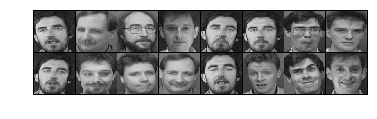

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


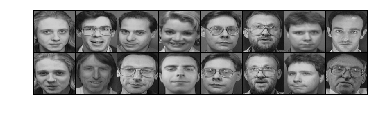

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [47]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

Iteration number 0
 Current loss 1.6308304071426392

Iteration number 1
 Current loss 1.6446874141693115

Iteration number 2
 Current loss 0.8892416954040527

Iteration number 3
 Current loss 0.6737010478973389

Iteration number 4
 Current loss 0.5309610962867737

Iteration number 5
 Current loss 1.8145017623901367

Iteration number 6
 Current loss 0.49727532267570496

Iteration number 7
 Current loss 0.6707321405410767

Iteration number 8
 Current loss 0.3481338918209076

Iteration number 9
 Current loss 0.2463713437318802

Iteration number 10
 Current loss 0.16430765390396118

Iteration number 11
 Current loss 0.1898985207080841

Iteration number 12
 Current loss 0.12083522975444794

Iteration number 13
 Current loss 0.0835508406162262

Iteration number 14
 Current loss 0.12387952208518982

Iteration number 15
 Current loss 0.14451384544372559

Iteration number 16
 Current loss 0.0750419944524765

Iteration number 17
 Current loss 0.14371003210544586

Iteration number 18
 Current los

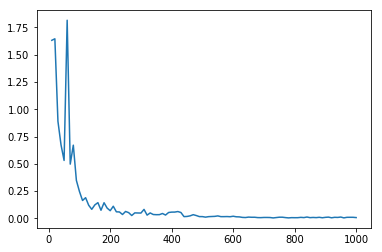

Iteration number 0
 Current loss 1.7573087215423584

Iteration number 1
 Current loss 1.8565750122070312

Iteration number 2
 Current loss 1.2462520599365234

Iteration number 3
 Current loss 0.38320451974868774

Iteration number 4
 Current loss 0.5598241090774536

Iteration number 5
 Current loss 0.2492068111896515

Iteration number 6
 Current loss 0.2272430658340454

Iteration number 7
 Current loss 0.21088099479675293

Iteration number 8
 Current loss 0.34357643127441406

Iteration number 9
 Current loss 0.14213861525058746

Iteration number 10
 Current loss 0.13162530958652496

Iteration number 11
 Current loss 0.18506640195846558

Iteration number 12
 Current loss 0.1115044504404068

Iteration number 13
 Current loss 0.11219146102666855

Iteration number 14
 Current loss 0.09720773994922638

Iteration number 15
 Current loss 0.15038733184337616

Iteration number 16
 Current loss 0.08990536630153656

Iteration number 17
 Current loss 0.0947432592511177

Iteration number 18
 Current

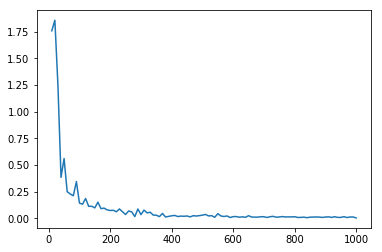

In [53]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Iteration number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

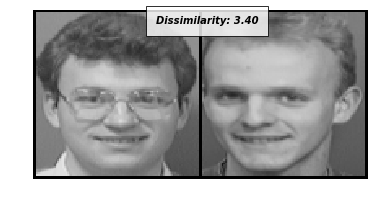

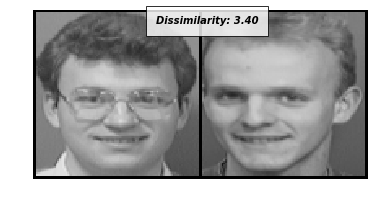

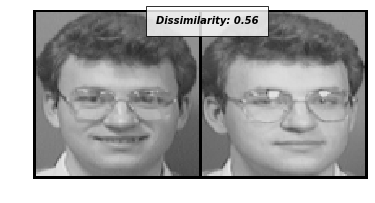

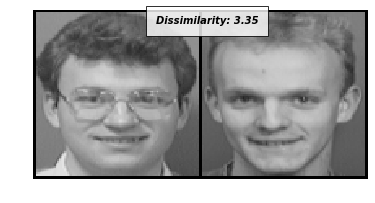

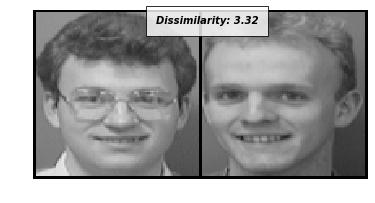

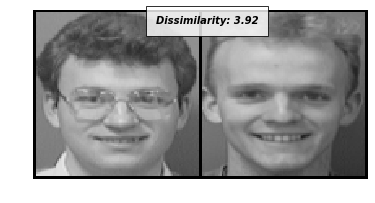

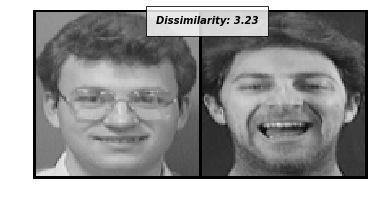

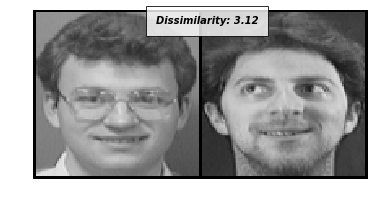

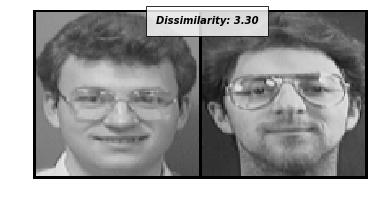

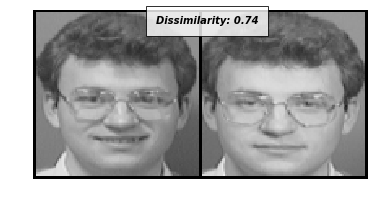

In [54]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True) # This is training set
dataiter = iter(test_dataloader)# this is testing set
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



In [55]:
print("The state dict keys: \n\n", net.state_dict().keys())

The state dict keys: 

 odict_keys(['cnn1.1.weight', 'cnn1.1.bias', 'cnn1.3.weight', 'cnn1.3.bias', 'cnn1.3.running_mean', 'cnn1.3.running_var', 'cnn1.3.num_batches_tracked', 'cnn1.5.weight', 'cnn1.5.bias', 'cnn1.7.weight', 'cnn1.7.bias', 'cnn1.7.running_mean', 'cnn1.7.running_var', 'cnn1.7.num_batches_tracked', 'cnn1.9.weight', 'cnn1.9.bias', 'cnn1.11.weight', 'cnn1.11.bias', 'cnn1.11.running_mean', 'cnn1.11.running_var', 'cnn1.11.num_batches_tracked', 'fc1.0.weight', 'fc1.0.bias', 'fc1.2.weight', 'fc1.2.bias', 'fc1.4.weight', 'fc1.4.bias'])


In [0]:
#!ls

In [57]:
!ls "/content/drive/My Drive/Colab Notebooks/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master"

checkpoint.pth	LICENSE			       Siamese-using-faces.ipynb
conda-env.yml	README.md		       Train_images
data		Siamese-networks-medium.ipynb  Validation_images


In [58]:
checkpoint = {'net':SiameseNetwork(),
              'state_dict': net.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save({'state_dict': net.state_dict()}, "/content/drive/My Drive/Colab Notebooks/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/checkpoint.pth")
print(checkpoint)

def load_checkpoint(filepath):
  
    #zunair's addition
#     model = TheModelClass(*args, **kwargs)
#     model.load_state_dict(torch.load(PATH))

#     checkpoint = torch.load(filepath)
    net = checkpoint['net']
    net.load_state_dict(checkpoint['state_dict'])
    for parameter in net.parameters():
        parameter.requires_grad = False
    
    net.eval()
    
    return net

net=load_checkpoint('/content/drive/My Drive/Colab Notebooks/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/checkpoint_faces.pth')
print(net)
#orch.save(checkpoint, 'checkpoint.pth')

{'net': SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
), 'state_dict': OrderedDict([('cnn1.1.weight', tensor([[[[-0.3230, -0

In [59]:
'''net = SiameseNetwork()
checkpoint1 = torch.load('checkpoint.pth')
print(checkpoint1)
net.load_state_dict(checkpoint['state_dict'])'''

"net = SiameseNetwork()\ncheckpoint1 = torch.load('checkpoint.pth')\nprint(checkpoint1)\nnet.load_state_dict(checkpoint['state_dict'])"

In [60]:
'''# original saved file with DataParallel
state_dict = torch.load('checkpoint.pth.tar')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
net.load_state_dict(new_state_dict)'''

"# original saved file with DataParallel\nstate_dict = torch.load('checkpoint.pth.tar')\n# create new OrderedDict that does not contain `module.`\nfrom collections import OrderedDict\nnew_state_dict = OrderedDict()\nfor k, v in state_dict.items():\n    name = k[7:] # remove `module.`\n    new_state_dict[name] = v\n# load params\nnet.load_state_dict(new_state_dict)"